In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randrange, uniform
import PIL

In [2]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_EXAMPLES_CELL = CDPP_EXAMPLES.joinpath('cell-devs')
CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')


<span style="color:red">Fijarse de cambiarlo dependiendo de donde tengan las cosas</span>.

In [3]:
majority_folder = str(CDPP_EXAMPLES_CELL)+"/majority"

In [4]:
majority_folder

'/home/seduser/SED/CDPP_ExtendedStates-codename-Santi/examples/cell-devs/majority'

In [5]:
def run_majority():
    command = "cd "+ majority_folder + " && ../../../src/bin/cd++ -m majority.ma -l majority.log -t 00:32:00:000"
    os.system(command)  

In [6]:
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

In [7]:
def numpy_arrays_from_log(rows, columns):
    log_path= majority_folder + "/majority.log01"
    with open(log_path) as f:
        lines = f.readlines()
    lines = list(filter(lambda x : "out" in x, lines))
    times = list(map(lambda x : time_to_secs((x.split("/")[3])), lines))
    values = list(map(lambda x : float((x.split("/")[6]).strip()), lines))
    positions = list(map(lambda x : (x.split("/")[4].split("(")[1].split(")")[0]).split(","), lines))
    positions = list(map(lambda x : (int(x[0]), int(x[1]) ), positions) )

    current_values = np.array(values[:rows*columns]).reshape((rows, columns))
    current_t = times[0]
    grids = []
    for t, v, pos in zip(times,values,positions):
        if current_t != t:
            current_t = t
            grids.append(np.copy(current_values))
        i, j = pos
        current_values[i][j] = v
    grids.append(current_values)

    return grids

In [8]:
def get_global_vote_series(grids):
    return [np.mean(x) for x in grids]

In [9]:
def set_model_grid_size(rows, columns):
    ma_path= majority_folder + "/majority.ma"

    with open(ma_path, 'r') as file:
        lines = file.readlines()
    dim_ind = filter( lambda x: "dim : " in x[1], enumerate(lines))
    dim_ind = next(map(lambda x: x[0], dim_ind))
    lines[dim_ind] = "dim : (" + str(rows) + "," + str(columns) + ")\n"
    with open(ma_path, 'w') as file:
        file.writelines( lines )

In [10]:
def initial_val_generator(rows, columns, p=0.5):
    val_path= majority_folder + "/majority.val"
    lines = []
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  int(uniform(0,1) > p)
            lines.append(pos + str(val) + "\n")

            # lines.append(pos + "[" + str(val) + ",0]" + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )

In [11]:
def get_clusters(grid):
    rows, columns = grid.shape[0], grid.shape[1]
    not_seen = set()
    for i in range(rows):
        for j in range(columns):
            not_seen.add((i,j))
            
    
    clusters = []
    n_clusters = 0
    
    while len(not_seen) > 0:
        current_cluster = set()
        i, j = not_seen.pop()
        current_color = grid[i][j]
        visited = set()
        to_search = {(i,j)}
        
        while len(to_search) > 0:
            i, j = to_search.pop()
            
            if (i,j) in visited:
                continue
            
            visited.add((i,j))
            
            if current_color == grid[i][j]:
                current_cluster.add((i,j))
                
                for di, dj in [(-1,-1),(1,-1),(-1,1),(1,1)]:
                    to_search.add(((i+di)%rows, (j+dj)%columns))
                    
        clusters.append(current_cluster)
        n_clusters += 1
        not_seen = not_seen - current_cluster
        

    return n_clusters

In [71]:
def from_image(path, resize=(40,40)):
    im = (PIL.Image.open(path))
    im = im.resize(resize)
    im = np.asarray(im)
    im = np.mean(im,axis=2)
    im = im >124 # ligeramente mas bajo para que se vea mejor
    #im = im > np.mean(im)
    return im

def grid_to_val(grid):
    val_path= majority_folder + "/majority.val"
    lines = []
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  grid[i][j]
            lines.append(pos + str(val) + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )
        
def img_to_val(path, resize=(40,40)):
    grid_to_val(from_image(path, resize=resize))

(-0.5, 99.5, 99.5, -0.5)

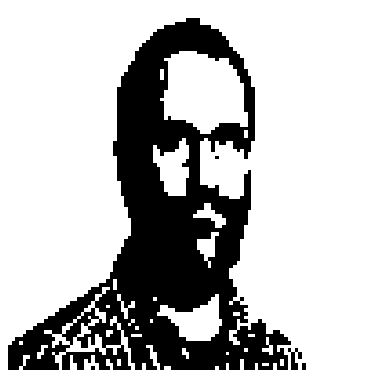

In [72]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

im = from_image("Rodrigo-Castro.jpg", (100,100))
plt.imshow(255-im, cmap="Greys")
plt.axis('off')

In [12]:
columns = 40
rows = 40

In [49]:
initial_val_generator(rows,columns)

In [50]:
set_model_grid_size(rows,columns)

In [71]:
run_majority()

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision = 5


Simulation complete!
Simulation ended!
LP 0 has finished simulation 


In [72]:
grids = numpy_arrays_from_log(rows,columns)

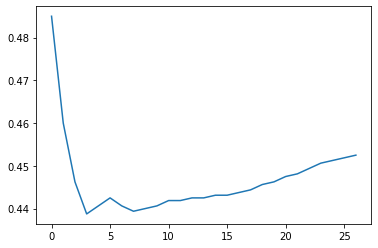

In [73]:
plt.plot(get_global_vote_series(grids))

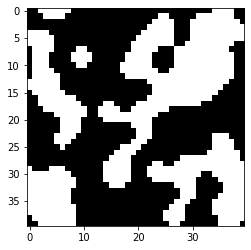

In [77]:
plt.imshow(1-grids[10], cmap="Greys")


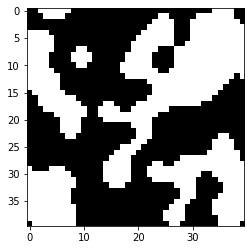

In [78]:
plt.imshow(1-grids[24], cmap="Greys")


In [67]:
imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
imgs[0].save(fp="run6.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)


<div>
<img src="run6.gif" width=300 />
</div>

### Numero de clusters

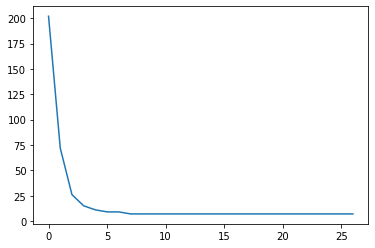

In [79]:
clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
plt.plot(clusters)

### Porcentaje de 1 para distintas probabilidades iniciales

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision = 5


Simulation complete!
Simulation ended!
LP 0 has finished simulation 


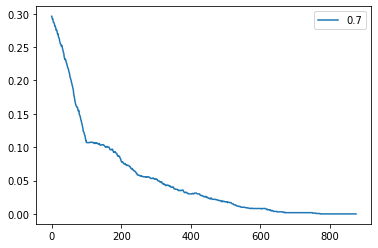

In [43]:
for p in [0.2, 0.4, 0.5]:
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    plt.plot(get_global_vote_series(grids), label=str(p))
    plt.legend()

### Numero de clusters para distintas probabilidades iniciales

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: majority.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision = 5


Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: majority.log
Output to: /dev/null
Tolerance set to: 

Simulation complete!
Simulation ended!
LP 0 has finished simulation 
PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from majority.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: majority.log
Output to: /dev/null
Tolerance set to: 

Simulation complete!
Simulation ended!
LP 0 has finished simulation 


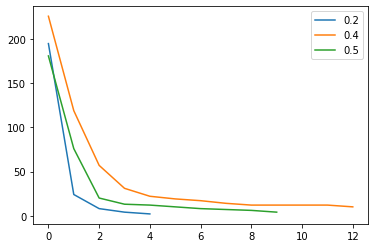

In [30]:
for p in [0.2, 0.4, 0.5]:
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    plt.plot(clusters, label=str(p))
    plt.legend()

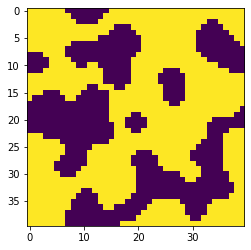

In [310]:
plt.imshow(grids[17])


In [31]:
numpy_arrays_from_log()

['0 / L / Y / 00:00:00:000:0 / grid(0,0)(02) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(0,1)(03) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(0,2)(04) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(0,3)(05) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(0,4)(06) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(1,0)(07) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(1,1)(08) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(1,2)(09) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(1,3)(10) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(1,4)(11) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(2,0)(12) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0 / grid(2,1)(13) / out /      0.00000 / grid(01)\n',
 '0 / L / Y / 00:00:00:000:0